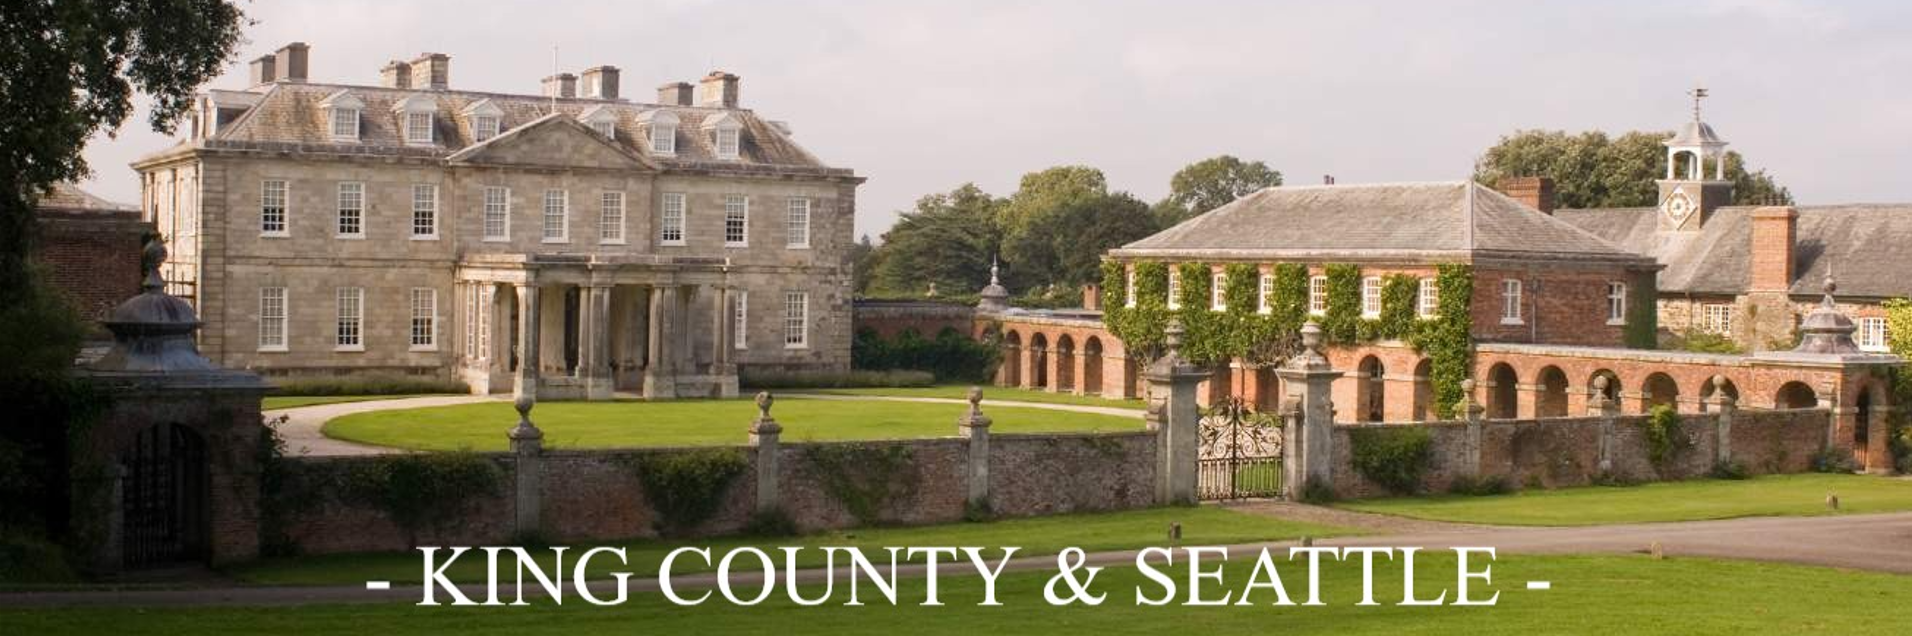

**NOTAS - Para resolución del problema**  
· Los precios de las casas van de $75,000 a $7,700,000  
· Hemos utilizado modelos de Aprendizaje Supervisado  
· Random Forest y XGBoost --> Los elegimos porque capturan relaciones no lineales, interacciones complejas y son robustos a outliers; factores clave en predicción de precios de casas  
· No "Estandarizaremos" ya que solo es obligatorio en modelos que usan distancias o gradientes, como en Regresión Lineal, SGD / Ridge / Lasso; KNN; Redes neuronales  
· Feature "id" carece de relevancia, simplemente identifica la casa y no aporta valor. Lo hemos dejado para asegurarnos de que es así.

**NOTAS - Para decisiones ante overfitting**  
· < 5%:    "Muy bien - Sin overfitting significativo"  
· 5-10%:   "Aceptable - Overfitting bajo"  
· 10-15%:  "Revisar - Overfitting moderado, considerar tuning"  
· 15-20%:  "Problemático - Overfitting alto, requiere ajustes"   
· > 20%:   "Crítico - Modelo no confiable, rehacer"  
Por ejemplo, un R^2 de Train = 98% y un R^2 de Test = 84% implica un Overfitting moderado (14%) = tunear un poco

### **EJERCICIO 1: Encontrar los "features clave" que más impactan significativamente en el precio de las casas**

In [1286]:
# ========================
# IMPORTACIÓN DE LIBRERÍAS
# ========================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

seed = 1  # Semilla para reproducibilidad

In [1287]:
# ==================
# CARGAR DATASET
# ==================

df = pd.read_csv("king_county_houses_aa.csv")

In [1288]:
# ===============================================
# LIMPIEZA Y ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ===============================================

# Comprobar que no hay datos nulos y que las variables están en su unidad correcta 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [1289]:
# Cambiamos el formato de la columna 'date' a datetime, y nos quedamos con el periodo anual/mensual
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')
df['year_sold'] = df['date'].dt.year
df['month_sold'] = df['date'].dt.month
df.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_basement  yr_built  \
0      5650     1.0           0     0  ...              0      1955   
1      7242     2.0           0     0  ...            400      1951   
2     10000     1.0           0     0  ...              0      1933   
3      5000     1.0           0     0  ...            910      1965   
4      8080     1.0           0     0  ...              0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
0             0    98178  47.5112 -122.257           1340        5650   
1          1991    98125  47.7210 -122.319           1690        7639   
2             0    98028  47.7379 -122.233           2720        8062   
3             0    98136  47.5208 -122.393           1360        5000   
4             0    98074  47.6168 -122.045           1800        7503   

   year_sold  month_sold  
0       2014          10  
1       2014          12  
2       2015           2  
3       2014          12  
4       2015           2  

[5 rows x 23 columns]

Para evitar problemas en nuestro entrenamiento del modelo a causa del feature "date":
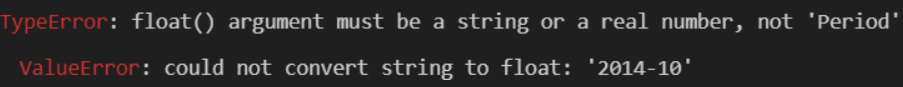  
--> Hemos separado la fecha en dos columnas "año" & "mes" y a continuación eliminamos "date" (debido a su formato)

In [1290]:
# Eliminación columna 'date' original
df = df.drop(['date'], axis=1)
#df.head()

In [1291]:
# ================================
# SEPARACIÓN DE FEATURES Y TARGET
# ================================

X = df.drop('price', axis=1)  # Todo menos Price
y = df['price']               # Solo Price (Target)

In [1292]:
# ======================================================
# DIVISIÓN TRAIN & TEST (80% ENTRENAMIENTO / 20% TEST)
# ======================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=seed
)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de prueba: {len(X_test)}")

Datos de entrenamiento: 17290
Datos de prueba: 4323


In [1293]:
# =================================================
# CREACIÓN Y ENTRENAMIENTO DEL MODELO RANDOM FOREST
# =================================================

# Creamos un Random Forest comenzando como mín con 100 árboles para regresión
rf_regressor = RandomForestRegressor(
    n_estimators=100,      # Número de árboles en el bosque
    max_depth=7,           # Profundidad máxima (más que en clasificación)
    random_state=seed,     # Reproducibilidad
    min_samples_split=2,   # Mínimo de muestras para dividir un nodo
    min_samples_leaf=1,    # Mínimo de muestras en cada hoja
    n_jobs=-1,             # Permite que el modelo use todos los núcleos de CPU disponibles para el entrenamiento, lo que puede acelerar el proceso.
    bootstrap=True         # El modelo utilizará el muestreo con reemplazo para construir los árboles, aumenta la variedad en los datos utilizados para cada árbol y puede mejorar el rendimiento del modelo.
)

# Entrenamos el modelo con los datos de entrenamiento
rf_regressor.fit(X_train, y_train)
print("Entrenado y listo para utilizar!🥳")

Entrenado y listo para utilizar!🥳


In [1294]:
# =======================
# PREDICCIÓN Y EVALUACIÓN
# =======================

# Hacemos predicciones sobre los datos de prueba
y_pred = rf_regressor.predict(X_test)

# Calculamos las métricas de regresión
mse = mean_squared_error(y_test, y_pred)    # Error Cuadrático Medio
rmse = np.sqrt(mse)                         # Raíz del Error Cuadrático Medio
r2_test = r2_score(y_test, y_pred)          # Coeficiente de Determinación R²

y_pred_train = rf_regressor.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)

# Evaluación del modelo
print("Evaluación con modelo Random Forest Regressor:")
print("="*46)
print(f"RMSE: ${rmse:,.0f}") # Nos dice cuánto se equivoca el modelo de media
print(f"R² TEST:  {r2_test:.2%}") # Indica qué % de los precios reales explica el modelo en datos nuevos (test), siendo el resto Ruido.
print(f"R² TRAIN: {r2_train:.2%}") # Lo mismo que R² TEST, pero en datos que el modelo ya vio (train). Y siempre será más alto que R² TEST (si no, hay algo mal hecho)
print(f"Diferencia: {(r2_train - r2_test)*100:.2f}%") # Mide si el modelo tiene overfitting

Evaluación con modelo Random Forest Regressor:
RMSE: $178,287
R² TEST:  81.58%
R² TRAIN: 86.82%
Diferencia: 5.24%


· **< 5%:    "Muy bien - Sin overfitting significativo"**  
· **5-10%:   "Aceptable - Overfitting bajo"**  
· 10-15%:  "Revisar - Overfitting moderado, considerar tuning" 

In [1295]:
# =================================
# EJEMPLO DE PREDICCIÓN INDIVIDUAL
# =================================

# Elegimos una casa del "test set" (cambia número para elegir otra casa)
indice_casa = 1

# Datos de la casa y precio real
casa = X_test.iloc[[indice_casa]]
precio_real = y_test.iloc[indice_casa]

# Predicción con Random Forest
predicted_value = rf_regressor.predict(casa)

# Evaluación
print(f"Random Forest - Predicción Precio, Casa INDICE: {indice_casa:.0f}")
print("="*50)
print(f"Precio real:     ${precio_real:,.0f}")
print(f"Precio predicho: ${predicted_value[0]:,.0f}")
print(f"Diferencia:      ${abs(predicted_value[0] - precio_real):,.0f}")

Random Forest - Predicción Precio, Casa INDICE: 1
Precio real:     $445,000
Precio predicho: $412,979
Diferencia:      $32,021


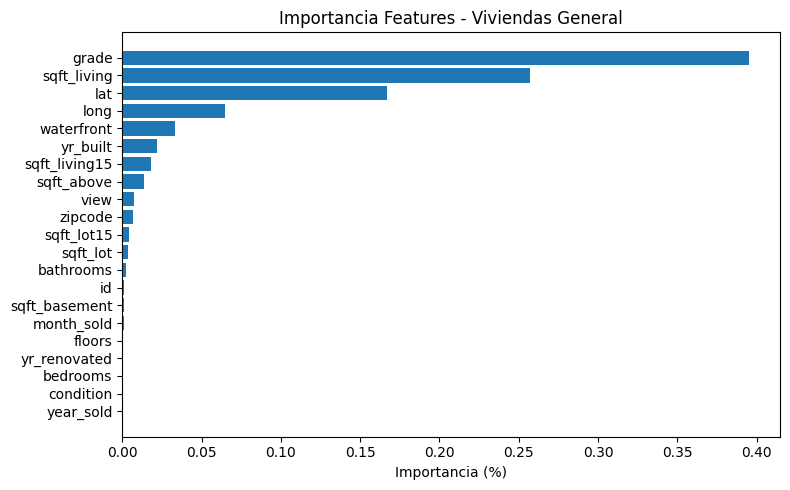

IMPORTANCIA FEATURES
 1. grade                     → 39.50%
 2. sqft_living               → 25.70%
 3. lat                       → 16.70%
 4. long                      →  6.46%
 5. waterfront                →  3.35%
 6. yr_built                  →  2.21%
 7. sqft_living15             →  1.82%
 8. sqft_above                →  1.38%
 9. view                      →  0.71%
10. zipcode                   →  0.69%
11. sqft_lot15                →  0.41%
12. sqft_lot                  →  0.35%
13. bathrooms                 →  0.21%
14. id                        →  0.13%
15. sqft_basement             →  0.12%
16. month_sold                →  0.08%
17. floors                    →  0.05%
18. yr_renovated              →  0.05%
19. bedrooms                  →  0.05%
20. condition                 →  0.03%
21. year_sold                 →  0.01%


In [1296]:
# ====================================
# IMPORTANCIA DE FEATURES - REGRESIÓN
# ====================================

# Obtenemos la importancia de cada feature
importance_df = pd.Series(rf_regressor.feature_importances_,
                          index=X.columns).sort_values(ascending=False)

# Creamos el gráfico
plt.figure(figsize=(8, 5))
plt.barh(importance_df.index, importance_df.values)
plt.gca().invert_yaxis() # Más importante arriba
plt.title('Importancia Features - Viviendas General')
plt.xlabel('Importancia (%)')
plt.tight_layout ()
plt.show()

# Mostramos los valores numéricos
print("IMPORTANCIA FEATURES")
print("="*50)
for i, (feat, imp) in enumerate(importance_df.head(21).items(), 1):
    print(f"{i:2}. {feat:25s} → {imp*100:5.2f}%")

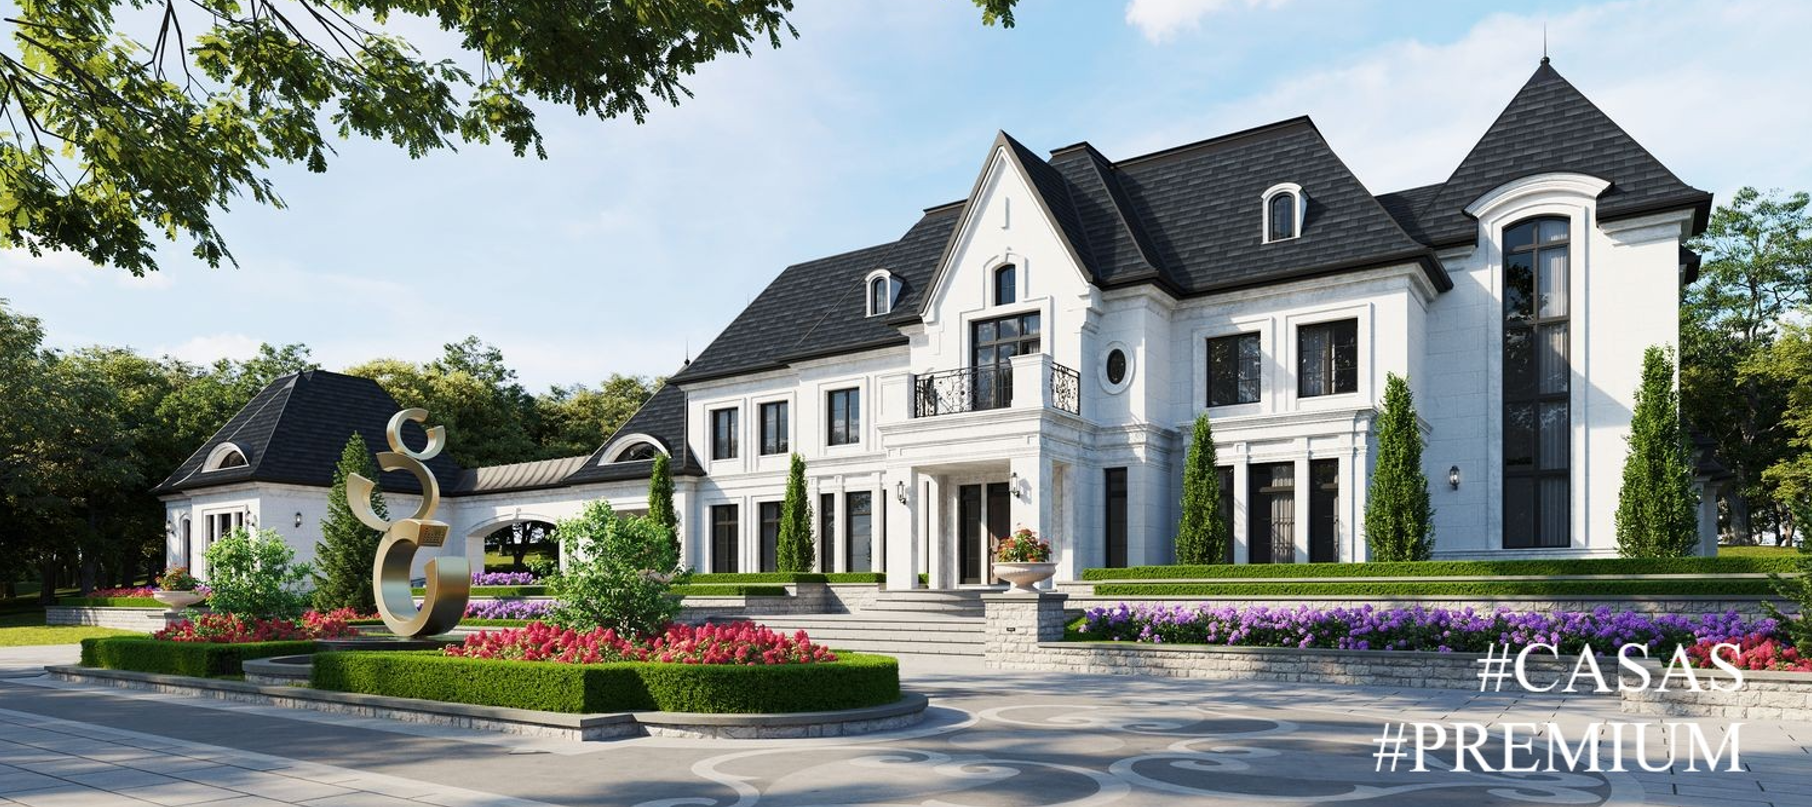

### **EJERCICIO 2: Explorar propiedades ≥ $650K (Casas Premium) para obtener información más detallada.**

In [1297]:
# ====================================================
# MODELO ESPECIALIZADO: SOLO CASAS PREMIUM ≥ $650k
# ====================================================

# 1. Crear el sub-dataset premium
casas_premium = df[df['price'] >= 650000].copy()

# 2. Separar features y target solo para premium
X_premium = casas_premium.drop('price', axis=1)
y_premium = casas_premium['price']

# 3. Train-test split solo en premium (80/20)
X_train_prem, X_test_prem, y_train_prem, y_test_prem = train_test_split(
    X_premium, y_premium, 
    test_size=0.2, 
    random_state=seed
)

# 4. Entrenar el mismo modelo solo con Viviendas Premium
rf_premium = RandomForestRegressor(
    n_estimators=500,          # Muchos árboles para estabilidad
    max_depth=12,               # Limita profundidad (clave contra overfitting)
    min_samples_leaf=6,         # Hojas con al menos 6 muestras
    min_samples_split=12,       # Splits con al menos 12 muestras
    max_features=0.6,           # Solo 60% de features por árbol (más diversidad)
    random_state=42,
    n_jobs=-1,
    bootstrap=True
)

rf_premium.fit(X_train_prem, y_train_prem)

# 5. Evaluación
y_pred_test_prem = rf_premium.predict(X_test_prem)
rmse_prem_rf = np.sqrt(mean_squared_error(y_test_prem, y_pred_test_prem))
r2_test_rf = r2_score(y_test_prem, y_pred_test_prem)

y_pred_train_prem = rf_premium.predict(X_train_prem)
r2_train_rf = r2_score(y_train_prem, y_pred_train_prem)

print(f"Random Forest - Viviendas Premium (≥ $650k)")
print("="*50)

print(f"Datos de entrenamiento: {len(X_train_prem)}")
print(f"Datos de prueba: {len(X_test_prem)}")
print("="*50)

print(f"R² TEST (Premium): {r2_test_rf*100:.2f}%") # Cuánto de la variabilidad de los datos explica el modelo
print(f"R² TRAIN (Premium): {r2_train_rf:.2%}")
print(f"Diferencia: {(r2_train_rf - r2_test_rf)*100:.2f}%")
print(f"RMSE (Premium): ${rmse_prem_rf:,.0f}") # Raíz del error cuadrático medio --> Diferencia entre la predicción del modelo y el valor real


Random Forest - Viviendas Premium (≥ $650k)
Datos de entrenamiento: 4259
Datos de prueba: 1065
R² TEST (Premium): 77.52%
R² TRAIN (Premium): 86.76%
Diferencia: 9.24%
RMSE (Premium): $200,529


Ya no tenemos tantas muestras como antes para el "entrenamiento"  
· ANTES (17290) Vs AHORA (4259)  
Lo mismo pasa con las "muestras para test"  
· ANTES (4323) Vs AHORA (1065) 

· < 5%:    "Muy bien - Sin overfitting significativo"  
· **5-10%:   "Aceptable - Overfitting bajo"**  
· 10-15%:  "Revisar - Overfitting moderado, considerar tuning" 

In [1298]:
# ===================================================
# PREDICCIÓN INDIVIDUAL SIMPLE: CASA PREMIUM ≥ $650k
# ===================================================

# Elegimos una casa premium del test set
indice = 10  # Hay que probar con diferentes índices para casa premium

# Datos de la casa y precio real
casa = X_test_prem.iloc[[indice]]
precio_real = y_test_prem.iloc[indice]

# Predicción con Random Forest para viviendas Premium
prediccion = rf_premium.predict(casa)[0]

# Resultado
print(f"Predicción con Random Forest, Casa Premium INDICE: {indice:.0f}")
print("="*55)

print(f"Precio Real:     ${precio_real:,.0f}")
print(f"Precio predicho: ${prediccion:,.0f}")
print(f"Diferencia:      ${abs(prediccion - precio_real):,.0f}")

if precio_real < 650000:
    print("Esta casa no es premium")

prediccion_rf_prem=prediccion
Diferencia_rf_prem=abs(prediccion_rf_prem - precio_real)

Predicción con Random Forest, Casa Premium INDICE: 10
Precio Real:     $890,000
Precio predicho: $825,941
Diferencia:      $64,059


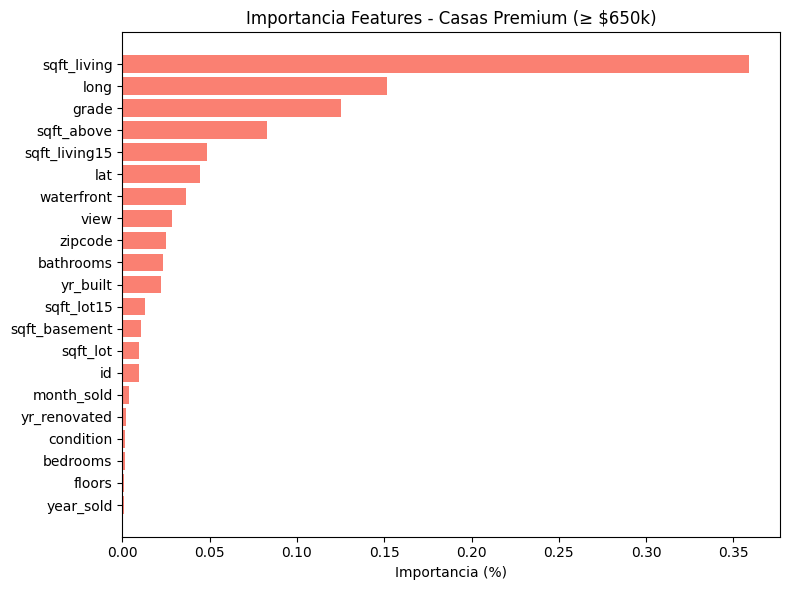


IMPORTANCIA FEATURES - CASAS PREMIUM
 1. sqft_living               → 35.87%
 2. long                      → 15.15%
 3. grade                     → 12.52%
 4. sqft_above                →  8.27%
 5. sqft_living15             →  4.86%
 6. lat                       →  4.45%
 7. waterfront                →  3.66%
 8. view                      →  2.86%
 9. zipcode                   →  2.50%
10. bathrooms                 →  2.31%
11. yr_built                  →  2.19%
12. sqft_lot15                →  1.31%
13. sqft_basement             →  1.07%
14. sqft_lot                  →  0.97%
15. id                        →  0.94%
16. month_sold                →  0.41%
17. yr_renovated              →  0.18%
18. condition                 →  0.17%
19. bedrooms                  →  0.15%
20. floors                    →  0.10%
21. year_sold                 →  0.08%


In [1299]:
# ===========================================
# IMPORTANCIA DE FEATURES - SEGMENTO PREMIUM
# ===========================================

# Con el modelo ya entrenado
importance_df = pd.Series(
    rf_premium.feature_importances_,
    index=X_train_prem.columns
).sort_values(ascending=False)

# Gráfico
plt.figure(figsize=(8, 6))
plt.barh(importance_df.index, importance_df.values, color='salmon')
plt.gca().invert_yaxis()  # Más importante arriba
plt.title('Importancia Features - Casas Premium (≥ $650k)')
plt.xlabel('Importancia (%)')
plt.tight_layout()
plt.show()

# Lista top
print("\nIMPORTANCIA FEATURES - CASAS PREMIUM")
print("="*50)
for i, (feat, imp) in enumerate(importance_df.head(21).items(), 1):
    print(f"{i:2}. {feat:25s} → {imp*100:5.2f}%")

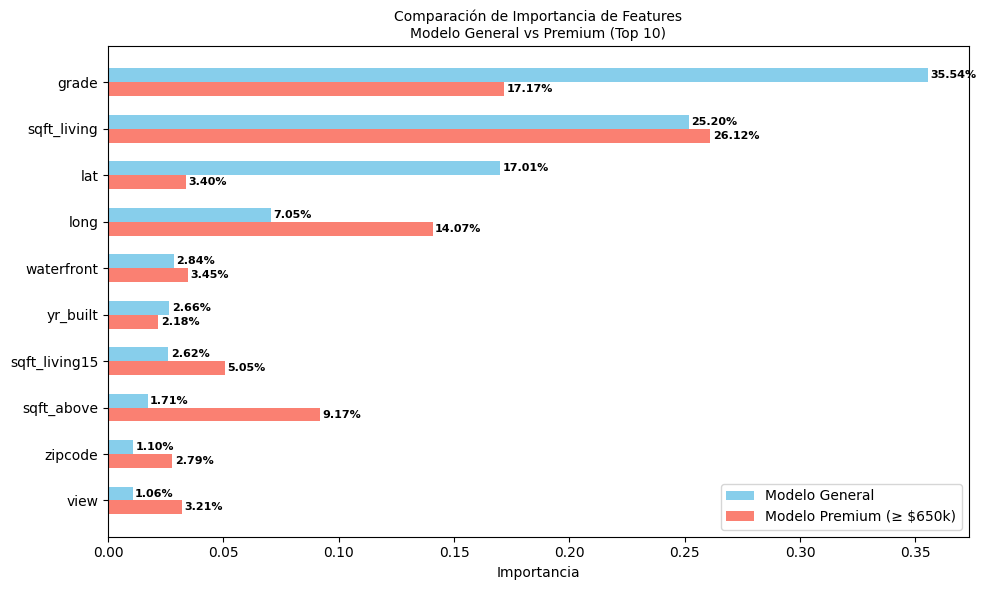


COMPARACIÓN TOP 10 FEATURES
 General_Rank General_Feature  General_Importancia (%)  Premium_Importancia (%)
            1           grade                    35.54                    17.17
            2     sqft_living                    25.20                    26.12
            3             lat                    17.01                     3.40
            4            long                     7.05                    14.07
            5      waterfront                     2.84                     3.45
            6        yr_built                     2.66                     2.18
            7   sqft_living15                     2.62                     5.05
            8      sqft_above                     1.71                     9.17
            9         zipcode                     1.10                     2.79
           10            view                     1.06                     3.21


In [1300]:
# ================================================
# COMPARACIÓN DE IMPORTANCIA DE FEATURES
# Modelo General vs Modelo Premium (≥ $650k)
# ================================================

# Aseguramos columnas comunes
common_features = imp_general.index.intersection(imp_premium.index)
imp_general = imp_general[common_features]
imp_premium = imp_premium[common_features]

# Top 10 features (orden descendente: más importante arriba)
top_features = imp_general.head(10).index[::-1]  # Invertido para más importante arriba

# Valores
general_values = [imp_general[f] for f in top_features]
premium_values = [imp_premium[f] if f in imp_premium.index else 0 for f in top_features]

# Posiciones Y con espacio entre grupos
n_features = len(top_features)
y_pos_general = np.arange(n_features * 2 - 1, -1, -2)  # Posiciones para general (arriba de cada par)
y_pos_premium = y_pos_general - 1                      # Posiciones para premium (debajo)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Barra General (arriba)
bars_general = ax.barh(y_pos_general - 0.8, general_values, height=0.6, color='skyblue', label='Modelo General')

# Barra Premium (debajo)
bars_premium = ax.barh(y_pos_premium + 0.8, premium_values, height=0.6, color='salmon', label='Modelo Premium (≥ $650k)')

# Etiquetas Y (solo el nombre de la feature, centrado entre las dos barras)
ax.set_yticks((y_pos_general + y_pos_premium) / 2)
ax.set_yticklabels(top_features)
ax.invert_yaxis()  # Más importante arriba

ax.set_xlabel('Importancia')
ax.set_title('Comparación de Importancia de Features\nModelo General vs Premium (Top 10)', fontsize=10)
ax.legend()

# Porcentajes al final de cada barra
for bars, values in [(bars_general, general_values), (bars_premium, premium_values)]:
    for bar, value in zip(bars, values):
        width = bar.get_width()
        ax.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f'{value*100:.2f}%', va='center', ha='left', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Tabla comparativa (top 10 de cada uno)
print("\nCOMPARACIÓN TOP 10 FEATURES")
print("="*70)
comparacion = pd.DataFrame({
    'General_Rank': range(1, 11),
    'General_Feature': imp_general.head(10).index,
    'General_Importancia (%)': (imp_general.head(10).values * 100).round(2),
    'Premium_Importancia (%)': [round(imp_premium[f]*100, 2) if f in imp_premium.index else 0.00 
                        for f in imp_general.head(10).index]
})
print(comparacion.to_string(index=False))

CONCLUSIONES  
La comparación de importancia de features es muy interesante:  
· En el modelo general, "grade" y "sqft_living" dominan (35% y 25%).  
· En el segmento premium, aunque el tamaño sigue siendo clave, hemos detectado evolución positiva de pesos en el resto de variables. 

· En el modelo general, la "lat" (latitud) es clave porque separa zonas caras del Norte de las más asequibles del Sur.  
· En el segmento premium, casi todas las casas ya están en el norte (alta latitud), por lo que "lat" pierde importancia (baja del 17% al 3.4%).  

· En cambio, la longitud (long), waterfront y el entorno (sqft_living15, zipcode) van ganando peso,
porque dentro del lujo, lo que marca la diferencia es estar en las zonas más exclusivas junto al lago o en barrios exclusivos  
· Esto confirma que en casas de lujo, la localización ("long" Este/Oeste) y el entorno premium son los features que más afectan al precio



### **BONUS: Predicción de precios de casas premium - Utilizando XGBoost** 

In [1301]:
# ================================================
# MODELO PREMIUM CON XGBoost
# ================================================

from xgboost import XGBRegressor

# Creamos el modelo
xgb_premium = XGBRegressor(
    n_estimators=1000,          # Mantenemos alto para compensar el aprendizaje más lento
    learning_rate=0.01,         
    max_depth=3,                
    subsample=0.5,              # Más bajo → más aleatoriedad, cada árbol ve el __% de los datos
    colsample_bytree=0.6,       
    reg_alpha=0.5,              # L1 → se encargar de penalizar uso de muchas features
    reg_lambda=5.0,             # L2 
    random_state=seed,
    n_jobs=-1
)

# Entrenamiento
xgb_premium.fit(X_train_prem, y_train_prem)

# Predicción y métricas
y_test_xgb = xgb_premium.predict(X_test_prem)
rmse_prem = np.sqrt(mean_squared_error(y_test_prem, y_test_xgb))
r2_test_prem = r2_score(y_test_prem, y_test_xgb)

y_train_xgb = xgb_premium.predict(X_train_prem)
r2_train_prem = r2_score(y_train_prem, y_train_xgb)


print(f"XGBoost - Casas Premium (≥ $650k)")
print("="*45)
print(f"R² TEST (Premium): {r2_test_prem*100:.2f}%") # Cuánto de la variabilidad de los datos explica el modelo
print(f"R² TRAIN (Premium): {r2_train_prem:.2%}")
print(f"Diferencia: {(r2_train_prem - r2_test_prem)*100:.2f}%")
print(f"RMSE (Premium): ${rmse_prem:,.0f}") # Raíz del error cuadrático medio --> Diferencia entre la predicción del modelo y el valor real

# Datos de Random Forest para comparar con XGBoost
print("\n" + f"Ranfom Forest - Casas Premium (≥ $650k)")
print("="*45)
print(f"R² TEST (Premium): {r2_test_rf*100:.2f}%") 
print(f"R² TRAIN (Premium): {r2_train_rf:.2%}") # Cuánto de la variabilidad de los datos explica el modelo
print(f"Diferencia: {(r2_train_rf - r2_test_rf)*100:.2f}%")
print(f"RMSE (Premium): ${rmse_prem_rf:,.0f}")

XGBoost - Casas Premium (≥ $650k)
R² TEST (Premium): 80.19%
R² TRAIN (Premium): 86.02%
Diferencia: 5.83%
RMSE (Premium): $188,240

Ranfom Forest - Casas Premium (≥ $650k)
R² TEST (Premium): 77.52%
R² TRAIN (Premium): 86.76%
Diferencia: 9.24%
RMSE (Premium): $200,529


· **XGBoost ~ (< 5%):    "Muy bien - Sin overfitting significativo"**  
· **Ranom Forest ~ (5-10%):   "Aceptable - Overfitting bajo"**  
· 10-15%:  "Revisar - Overfitting moderado, considerar tuning" 

In [1302]:
# ===========================================================
# PREDICCIÓN INDIVIDUAL SIMPLE CON XGBOOST: CASA PREMIUM
# ===========================================================

# indice = En este caso el "indice" está recogiendo el mismo número elegido
# anteriormente con Random Forest para la predicción simple de una casa premium

# Datos de la casa y precio real
casa = X_test_prem.iloc[[indice]]
precio_real = y_test_prem.iloc[indice]

# Mostramos TODAS las características de la casa (la fila completa)
print(f"CARACTERÍSTICAS CASA PREMIUM, INDICE: {indice:.0f}")
print("="*70)
print(casa)  # .T para ver vertical (más legible se quiere)
print("="*50)

# Predicción con XGBoost Modelo Premium
prediccion_xgb = xgb_premium.predict(casa)[0]

# Evaluación
print("\n" + f"Precio Real: ${precio_real:,.0f}")
print("="*50)

# Resultado
print("\n" + "Modelo XGBoost - Viviendas Premium (≥ $650k)")
print("="*50)

print(f"Precio Predicho (xgb): ${prediccion_xgb:,.0f}")
print(f"Diferencia (rgb):      ${abs(prediccion_xgb - precio_real):,.0f}")


# Predicción previa con Random Forest para viviendas Premium, para comparativa
print("\n" + "Random Forest - Viviendas Premium (≥ $650k)")
print("="*50)
print(f"Precio predicho (rf):  ${prediccion_rf_prem:,.0f}")
print(f"Diferencia (rf):       ${abs(prediccion_rf_prem - precio_real):,.0f}")

CARACTERÍSTICAS CASA PREMIUM, INDICE: 10
               id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
18964  2768200090         6       3.75         2770      5000     1.0   

       waterfront  view  condition  grade  ...  sqft_basement  yr_built  \
18964           0     0          3      8  ...            900      1969   

       yr_renovated  zipcode     lat     long  sqft_living15  sqft_lot15  \
18964             0    98107  47.669 -122.365           1570        2108   

       year_sold  month_sold  
18964       2015           3  

[1 rows x 21 columns]

Precio Real: $890,000

Modelo XGBoost - Viviendas Premium (≥ $650k)
Precio Predicho (xgb): $872,364
Diferencia (rgb):      $17,636

Random Forest - Viviendas Premium (≥ $650k)
Precio predicho (rf):  $825,941
Diferencia (rf):       $64,059
